## TV denoising using an ADMM algorithm

Autor: Clemens Sirotenko.<br> 
Coments:
* Algorithm implements denoising with ADMM
* Linear Systems are solved (this is the bottleneck of the method!) either with preconditioning based on LU factorization (faster) or CG-type mehtods (without preconditioning slower)
* The forward operators DX, DY are applied via matrix factorization. Using equivalent np.roll methods could further increase the speed!
* Currently there is no proper stopping criterion applied - I stop after a given number of iterations
* Next step is to extend the algorithm to the dynamic MRI case.

In [1]:
import numpy as np
import scipy.misc 
import matplotlib.pyplot as plt

import skimage.metrics as metr
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from scipy import sparse
import scipy.sparse.linalg

from skimage import io

In [2]:
#import test image
clean_image = scipy.misc.face(gray=True)
(n,m) = clean_image.shape
# downsampling
clean_image = clean_image[0:n-1:3,0:m-1:3]
clean_image = clean_image[0:256,50:306]
(n,m) = clean_image.shape
clean_image = clean_image/np.max(clean_image)

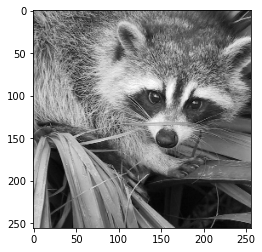

In [3]:
plt.imshow(clean_image,cmap='gray')
plt.show()

In [4]:
#helper functions
def DX_forward(u):
    return np.roll(u,-1,0) - u
def DX_backward(g1):
    return np.roll(g1,1,0) - g1
def DY_forward(u):
    return np.roll(u,-1,1) - u
def DY_backward(g1):
    return np.roll(g1,1,1) - g1 

In [5]:
## Helperfunctions

def psnr(image,reference):
    """
    Returns the PSNR of an image with respect to a given reference image.
    """
    return metr.peak_signal_noise_ratio(reference,image)

def normalize(image):
    """
    Gets a grey valued image $x = (x_{ij})_{i,j}$ wich pixel values in [a,b] = [ \min_{ij} x_{ij}, \max_{ij} x_{ij}]  
    """
    #image = image - np.min(image)
    image = image / np.max(image)
    return image

def subsampling(image,mask):
    """
    Gets an image and a binary mask with values in [0,1] and gives back the image values at the location where the 
    mask is one.
    """
    indexes = mask > 0.5
    return image[indexes]

def subsampling_transposed(data_vec,mask):
    """
    Transposed of the subsampling operator
    """
    indexes = mask>0.5
    height, width = mask.shape
    M = height
    N = width
    result = np.zeros((M,N),dtype = complex)
    result[indexes] = data_vec
    return result

def compute_differential_operators(N,M,h):
    """
    This method creates sparse representation matrices of forward finite differences 
    as in the book by christian bredies[Bredies20]
    """
    #compute D_y as a sparse NM x NM matrix
    one_vec = np.ones((M-1)*N)
    diag = np.array(one_vec)
    offsets = np.array([0])
    sp_help_matr_1 = - sparse.dia_matrix((diag,offsets), shape=(N*M,N*M))
    sp_help_matr_2 = sparse.eye(N*M,k=N)
    D_x_sparse = (1/h)*(sp_help_matr_1 + sp_help_matr_2)
    
    # compute D_x as a sparse NM x NM  matrix
    E_M = sparse.eye(M)
    one_vec =  - np.ones(N-1)
    offsets = np.array([0])
    sp_matr_help_1 = sparse.dia_matrix((one_vec,offsets), shape=(N,N))
    sp_matr_help_2 = sparse.eye(N,k=1)
    sp_matr_help_3 = sp_matr_help_1 + sp_matr_help_2
    D_y_sparse = (1/h)*sparse.kron(E_M,sp_matr_help_3)
    
    #compute gradient as a sparse NM x 2NM
    grad = sparse.vstack([D_x_sparse,D_y_sparse])
    
    #compute divergence as a sparse 2NM x NM
    sparse_div_x = - D_x_sparse.transpose() 
    sparse_div_y = - D_y_sparse.transpose()
    div = sparse.hstack([sparse_div_x, sparse_div_y])
    
    return D_x_sparse, D_y_sparse, grad, div

In [6]:
def prox(alpha,x):
    prox_output = x
    prox_output = np.sign(x)*np.maximum(np.abs(x) -  alpha,0)
    return prox_output

In [7]:
from scipy.sparse.linalg import factorized

In [8]:
def make_u_step_denoising_matrix(u_k,z_k,mu_k,DX,DY,f,beta,lhs_solve_lu,verbose):
    (m,n) = np.shape(u_k)
    #lhs_matrix = sparse.eye(n*m) + beta*(DX.transpose().dot(DX) + DY.transpose().dot(DY))
    rhs = f.ravel() + (DX.transpose().dot(beta*z_k[:,:,0].ravel() - mu_k[:,:,0].ravel()) + 
            DY.transpose().dot(beta*z_k[:,:,1].ravel() - mu_k[:,:,1].ravel()))
    #u_next_vector,info = scipy.sparse.linalg.bicgstab(lhs_matrix, rhs, x0=u_k.ravel(),tol=1e-7)
    #solve = factorized(lhs_matrix)
    u_next_vector = lhs_solve_lu(rhs)
    #u_next_vector = scipy.sparse.linalg.spsolve(lhs_matrix,rhs)
    info = 1
    if verbose:
        if info == 0:
            print('CG convergence successful')
        else:
            print('CG did not converge')
    return np.reshape(u_next_vector,(m,n))

In [9]:
def ADMM_denoising(u_0,f,alpha,beta,max_iter,verbose):
    (m,n) = np.shape(u_0)
    DX,DY,div_X,div_Y = compute_differential_operators(m,n,1)
    lhs_matrix = sparse.eye(n*m) + beta*(DX.transpose().dot(DX) + DY.transpose().dot(DY))
    solve = factorized(lhs_matrix)
    u_k = u_0
    z_k = np.zeros((m,n,2))
    z_k[:,:,0] = np.reshape(DX.dot(u_k.ravel()),(m,n))
    z_k[:,:,1] = np.reshape(DY.dot(u_k.ravel()),(m,n))
    mu_k = np.zeros((m,n,2))
    ite = 1;
    while ite < max_iter:
        u_next = make_u_step_denoising_matrix(u_k,z_k,mu_k,DX,DY,f,beta,solve,verbose)
        z_next = z_k
        z_next[:,:,0] = prox(alpha/beta, mu_k[:,:,0]/beta + np.reshape(DX.dot(u_next.ravel()),(m,n)))
        z_next[:,:,1] = prox(alpha/beta, mu_k[:,:,1]/beta + np.reshape(DY.dot(u_next.ravel()),(m,n)))
        mu_next = mu_k
        mu_next[:,:,0] = mu_k[:,:,0] + beta*(np.reshape(DX.dot(u_next.ravel()),(m,n)) - z_next[:,:,0])
        mu_next[:,:,1] = mu_k[:,:,1] + beta*(np.reshape(DY.dot(u_next.ravel()),(m,n)) - z_next[:,:,1])
    
        u_k = u_next
        z_k = z_next
        mu_k = mu_next
        ite = ite + 1
        #print(np.linalg.norm(u_k - f))
        #print(np.linalg.norm(np.reshape(DX.dot(u_next.ravel()),(m,n)) - z_k[:,:,0]) + 
        #     np.linalg.norm(np.reshape(DY.dot(u_next.ravel()),(m,n)) - z_k[:,:,1]))
        #plt.imshow(u_k,cmap='gray')
        #plt.show()
    return u_k,z_k


In [10]:
# generate test_data 
rate = 0.15
(m,n) = np.shape(clean_image)
noisy_data = clean_image + rate*np.random.randn(m,n)
max_iter = 60
u_0 = noisy_data
f = noisy_data
alpha = 0.09*np.ones((m,n))
beta = 1

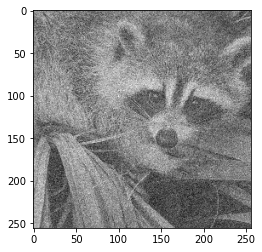

In [11]:
plt.imshow(noisy_data,cmap='gray')
plt.show()

In [12]:
# apply algorithm
u_rec,z_rec = ADMM_denoising(u_0,f,alpha,beta,max_iter,verbose=False)

C:\Users\cleme\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


### Show results

Clean image


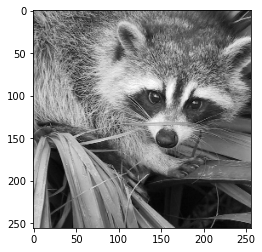

Noisy image,  PSNR: 16.499182807154234


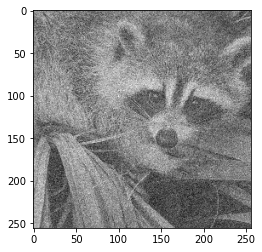

TV reconstruction,  PSNR: 22.242430781678088


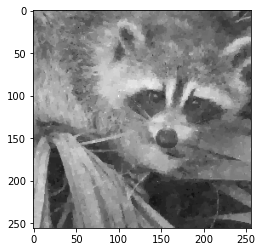

z variable approximation the image gradient


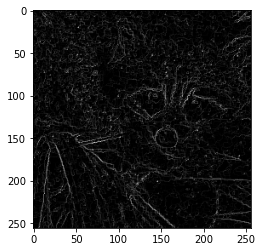

In [13]:
print('Clean image')
plt.imshow(clean_image,cmap='gray')
plt.show()
print('Noisy image,  PSNR: ' + str(psnr(noisy_data,clean_image)))
plt.imshow(noisy_data,cmap='gray')
plt.show()
print('TV reconstruction,  PSNR: ' + str(psnr(u_rec,clean_image)))
plt.imshow(u_rec,cmap='gray')
plt.show()
print('z variable approximation the image gradient')
plt.imshow(np.abs(z_rec[:,:,0]) + np.abs(z_rec[:,:,1]),cmap='gray')
plt.show()

### visualization of the typical staircasing artifacts using TV 
Looking at a cross section of the reconstruction we see typical staircase like behaviour of our solution

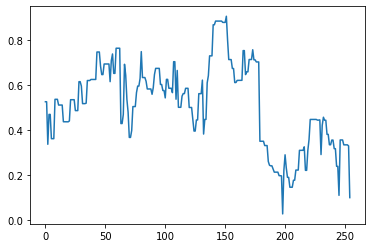

In [14]:
plt.plot(u_rec[128,1:256])
plt.show()